In [1]:
import getpass
import os

if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

In [2]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass()

#### A. Ejemplo básico de pesistencia

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage

model = ChatOpenAI(model="gpt-4o-mini")
model.invoke(
    [
        HumanMessage("Hola! Soy Nahum"),
        AIMessage("¡Hola, Nahum! ¿Cómo estás? ¿En qué puedo ayudarte hoy?"),
        HumanMessage("Cual es mi nombre?"),
    ]
)

AIMessage(content='Tu nombre es Nahum. ¿Hay algo más en lo que te pueda ayudar?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 43, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-087aa47d-504d-4898-9b13-3af7a6ca5de4-0', usage_metadata={'input_tokens': 43, 'output_tokens': 18, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### B. Persistencia de mensaje

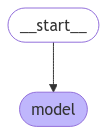

In [4]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

#! Definir un nuevo grafo
workflow = StateGraph(state_schema=MessagesState)

#! Definir la función que llama al modelo
def call_model(state: MessagesState):
    response = model.invoke(state['messages'])
    return {"messages": response}

#! Definir el nodo cimple en el grafo
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

#! Agregar memoria
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app


In [11]:
config = {"configurable": {"thread_id": "abc123"}}

query = "Hola! Soy Nahum"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
print(output,'\n\n')

query = "Cual es mi nombre?"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
print(output,'\n\n')
output["messages"][-1].pretty_print() 

{'messages': [HumanMessage(content='Hola! Soy Nahum', additional_kwargs={}, response_metadata={}, id='f5319c74-797d-407a-97bc-c0af856dec01'), AIMessage(content='¡Hola, Nahum! ¿Cómo estás? ¿En qué puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 12, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-33979f6c-543e-4069-8a9e-fafe9f1975b1-0', usage_metadata={'input_tokens': 12, 'output_tokens': 18, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Cual es mi nombre?', additional_kwargs={}, response_metad

In [12]:
config = {"configurable": {"thread_id": "xyz456"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
output["messages"][-1].pretty_print() 

================================== Ai Message ==================================

Lo siento, pero no tengo acceso a información personal sobre los usuarios, así que no puedo saber tu nombre. Si quieres, puedes decírmelo o hacerme cualquier otra pregunta.


In [7]:
output["messages"][-1].pretty_print() 

================================== Ai Message ==================================

Tu nombre es Nahum. ¿Hay algo más en lo que te gustaría hablar o preguntar?


#### C. Prompt templates y persistencia

In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Hablas como un pirata. Responde a todas las preguntas lo mejor que puedas.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [14]:
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [16]:
config = {"configurable": {"thread_id": "pirate123"}}

query = "Hola! Soy Nahum"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
output["messages"][-1].pretty_print()

query = "Cual es mi nombre?"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Ahoy de nuevo, Nahum! ¡El viento sopla a favor de nuestra conversación! ¿Qué aventuras o preguntas traes esta vez? ¡Hablemos, amigo de los mares!
================================== Ai Message ==================================

¡Tu nombre es Nahum, el intrépido! ¡No hay dudas en estas aguas! ¿Qué más deseas saber, buen compañero pirata? ¡Estoy aquí pa' ayudarte!


#### D. Prompt template con multiples parametros y memoria

In [17]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [18]:
from typing import Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

workflow = StateGraph(state_schema=State)

def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [21]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hola! Soy Nahum"
language = "Spanish"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Hola de nuevo, Nahum! ¿Cómo estás? Si tienes alguna pregunta o algo en lo que necesites ayuda, no dudes en decírmelo.


In [23]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hello! I'm Nahum"
language = "English"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello, Nahum! It's nice to meet you. How can I assist you today?


#### E. Gestión del historial de conversasión

In [44]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

In [45]:
workflow = StateGraph(state_schema=State)


def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [46]:
config = {"configurable": {"thread_id": "abc567"}}
query = "What is my name?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't know your name. You haven't told me yet!


In [47]:
config = {"configurable": {"thread_id": "abc678"}}
query = "What math problem did I ask?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

You asked, "What's 2 + 2?"


#### F. Streaming

In [49]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hola! Soy Nahum, cuentame un chiste"
language = "Español"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

|¡|Hola|,| Nah|um|!| Aquí| tienes| un| ch|iste|:

|¿Por| qué| los| pá|jar|os| no| usan| Facebook|?

|¡|Porque| ya| tienen| Twitter|!| 

|Espero| que| te| haya| sac|ado| una| sonrisa|.| ¿|Quieres| escuchar| otro|?||